# Taxi Routes

### Project Description: Create a program that can find the fastest route for a taxi within a city while considering speed and distance. The goal of the project is to mimic Google Maps and visualize how routes are created when there are many factors to account for.

## Gathering Map Data
Road data can be downloaded with [openstreetmap.org](https://www.openstreetmap.org) after specifying longitute/latitude bounds and exporting with the Overpass API option.

In [5]:
import xml.etree.ElementTree as ET
tree = ET.parse('map.xml')
root = tree.getroot()

# get bounds
boundsData = root.find('bounds').attrib
minX = float(boundsData['minlat'])
minY = float(boundsData['minlon'])
maxX = float(boundsData['maxlat'])
maxY = float(boundsData['maxlon'])

print("Latitude bounds\nlower: %f, upper:%f" % (minX, maxX))
print("Longitude bounds\nlower: %f, upper:%f" % (minY, maxY))

Latitude bounds
lower: 33.411100, upper:33.450600
Longitude bounds
lower: -111.956600, upper:-111.903000


### Another approach is to download a shapefile(.shp) of the area on [geofabrik.de](https://download.geofabrik.de/north-america/us.html). This is the map plotted out with the shapefile.

    osm_id  code        fclass                   name   ref oneway  maxspeed  \
0  5561436  5141       service                   None  None      B         0   
1  5565693  5133  primary_link                   None  None      F         0   
2  5584300  5141       service                   None  None      B         0   
3  5584509  5141       service                   None  None      B         0   
4  5587308  5122   residential  North Camellia Street  None      B        40   

   layer bridge tunnel                                           geometry  
0      0      F      F  LINESTRING (-111.95182 33.44411, -111.95185 33...  
1      0      F      F  LINESTRING (-111.94859 33.44458, -111.94873 33...  
2      0      F      F  LINESTRING (-111.95586 33.44872, -111.95577 33...  
3      0      F      F  LINESTRING (-111.95269 33.44945, -111.95224 33...  
4      0      F      F  LINESTRING (-111.92134 33.44801, -111.92135 33...  


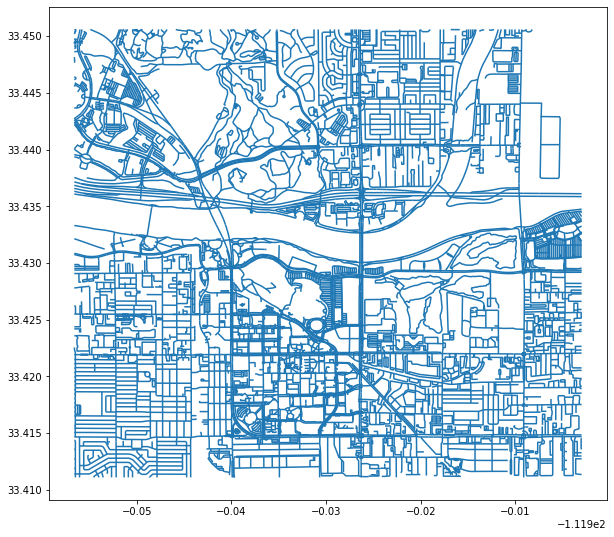

In [2]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt

metroMap = gpd.read_file('shp/tempeRoads.shp')
metroMap.plot(figsize=(10,10))
print(metroMap.head())

plt.show()

### Using the XML formatted data from Overpass API, the nodes and their corresponding coordinates can be plotted with geopandas. The XML formatted file is more detailed than the shapefile.

<AxesSubplot:>

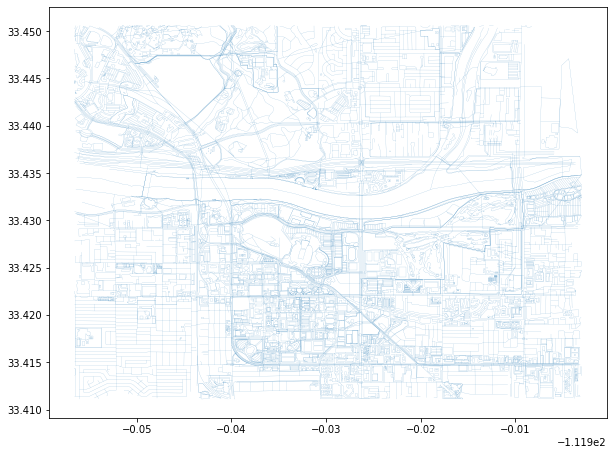

In [31]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

tree = ET.parse('map.xml')
root = tree.getroot()
nodes = dict()

# hash all nodes
for item in root.findall('node'):
    id = item.attrib.pop('id', None)
    nodes[id] = item.attrib

series = []

# draw all ways
for item in root.findall('way'):
    points = []
    for child in item.findall('nd'):
        node = nodes[child.attrib['ref']]
        lat = float(node['lat'])
        lon = float(node['lon'])

        # ensure that the nodes are within the area specified
        if lat >= minX and lat <= maxX and lon >= minY and lon <= maxY:
            # create a tuple of LONGTITUDE and LATITUDE for accurate map
            points.append((lon, lat))
    
    if len(points) >= 2:
        lineString = LineString(points)
        series.append(lineString)

tempeDataFrame = gpd.GeoDataFrame(geometry=series)
tempeDataFrame.plot(figsize=(10,10), linewidth=0.1)

### Extract and plot all road-related data

<AxesSubplot:>

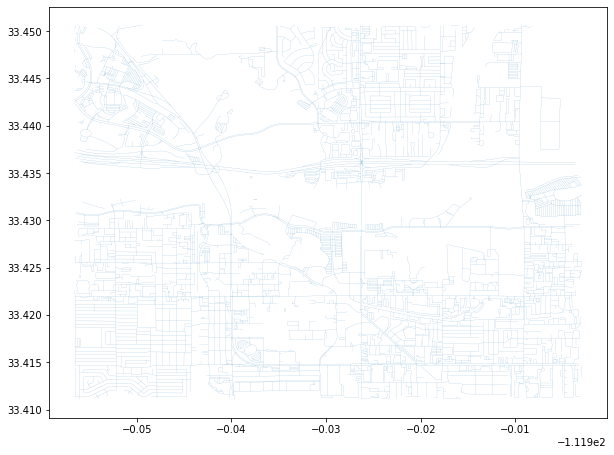

In [6]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

tree = ET.parse('map.xml')
root = tree.getroot()

graph = dict()
nodes = dict()
tagValues = set()

# hash all nodes
for item in root.findall('node'):
    id = item.attrib.pop('id', None)
    nodes[id] = item.attrib

    key = (float(nodes[id]['lon']), float(nodes[id]['lat']))
    values = graph.get(key, None)
    #print(key)

    if values == None:
        graph[key] = []

series = []

# draw all ways
for item in root.findall('way'):
    # check that the way is a car friendly
    filters = ['footway', 'path', 'cycleway', 'pedestrian', 'steps', 'track', 'dismantled']

    keys = ['maxspeed', 'highway', 'lanes', 'service']

    roadType = False
    for tag in item.findall('tag'):
        if tag.attrib['k'] in keys and tag.attrib['v'] not in filters:
            roadType = True
            tagValues.add(tag.attrib['v'])
    
    if roadType == False:
        continue

    points = []
    for child in item.findall('nd'):
        node = nodes[child.attrib['ref']]
        lat = float(node['lat'])
        lon = float(node['lon'])

        # ensure that the nodes are within the area specified
        if lat >= minX and lat <= maxX and lon >= minY and lon <= maxY:
            # create a tuple of LONGTITUDE and LATITUDE for accurate map
            points.append((lon, lat))

    if len(points) >= 2:
        lineString = LineString(points)
        series.append(lineString)

        for i in range(len(points) - 1):
            if points[i] not in graph or points[i + 1] not in graph:
                continue
            values = graph.get(points[i], [])
            values.append(points[i + 1])
            graph[points[i]] = values

tempeDataFrame = gpd.GeoDataFrame(geometry=series)
tempeDataFrame.plot(figsize=(10,10), linewidth=0.1)

#print(tagValues)
#print(graph)

### Perform BFS starting from an arbitrary coordinate

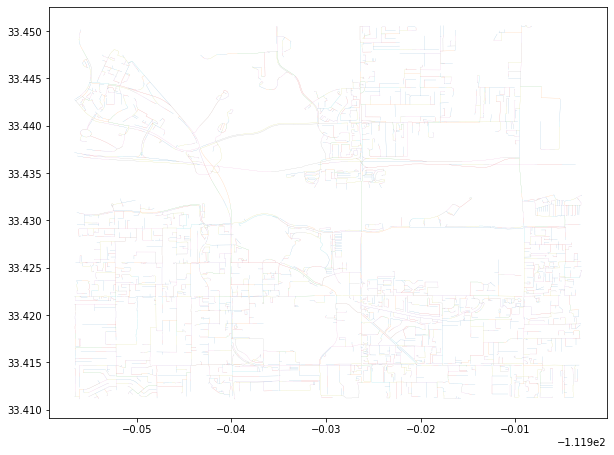

In [13]:
import networkx as nx
from matplotlib.colors import ListedColormap
import heapq
import copy

G = nx.DiGraph()
# Hayden Parking Garage Start
#src = (-111.9386591, 33.4301382)

# Hayden Butte Preserve entrance
src = (-111.9389779, 33.4293868)

for key in graph:
    G.add_node(key)
    for nodeValue in graph.get(key, []):
        distance = ((key[0] - nodeValue[0]) ** 2 + (key[1] - nodeValue[1]) ** 2) ** 0.5
        distance *= 1000000
        G.add_edge(key, nodeValue, weight=distance)
        #G.add_edge(nodeValue, key, weight=distance)

adjacencyTable = dict()
for elem in G.adjacency():
    if len(elem[1]) != 0:
        adjacencyTable[elem[0]] = elem[1]

pathTable = dict()
visited = set()
unvisited = set(G.nodes)
heap = []
heapq.heappush(heap, (0, src))
distance = dict()

while len(heap) is not 0:
    curr = heapq.heappop(heap)
    if curr[1] in visited:
        continue
    unvisited.remove(curr[1])
    visited.add(curr[1])
    
    for neighbor in adjacencyTable.get(curr[1], []):
        if neighbor in visited:
            continue
        weight = adjacencyTable[curr[1]][neighbor]['weight'] + curr[0]

        # update distance to current node
        currDistance = distance.get(neighbor, sys.float_info.max)
        currDistance = min(currDistance, weight)
        distance[neighbor] = currDistance

        # add neighbor to queue
        heapq.heappush(heap, (weight, neighbor))
        path = pathTable.get(curr[1], [])
        path = copy.deepcopy(path)
        path.append(neighbor)
        pathTable[neighbor] = path
    

occurrences = dict()
for dst in pathTable:
    pathList = pathTable.get(dst, [])
    pathList.insert(0, src)
    if len(pathList) < 2:
        continue

    for i in range(len(pathList) - 1):
        amount = occurrences.get((pathList[i], pathList[i + 1]), 0)
        amount = str(int(amount) + 1)
        occurrences[(pathList[i], pathList[i + 1])] = amount

#print(occurrences)

series = []
column = []
for edge in occurrences:
    series.append(LineString([edge[0], edge[1]]))
    column.append(occurrences[edge])

'''for node1 in adjacencyTable:
    for node2 in adjacencyTable.get(node1, {}):
        if (node1, node2) not in occurrences:
            series.append(LineString([node1, node2]))
            column.append('0')'''

#print(distance)
frame = gpd.GeoDataFrame({'visits': column, 'geometry': series})
#frame = gpd.GeoDataFrame({'geometry': series})
frame.plot(figsize=(10,10), linewidth=0.1, column='visits')
#ax = frame.plot(figsize=(10,10), linewidth=0.1, column='visits')
#frame.apply(lambda x: ax.annotate(s=x['visits'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

print()

## Tools
 - OpenStreetMap
 - Geopandas
 - Matplotlib